## User Identification from Walking Activity: Insights and Predcitions

**By: Manjula Mishra**


**The Goal**

The goal of this project is to understand individual walking styles and to generate relevant insights to help our company develop persolized recommendations based on the walking habits and behaviors of our users/customers. 


**The Data**

The dataset **User Identification From Walking Activity Data Set** was dowloaded from UCI Machine Learning Repository. The dataset consists of 22 individual files (plus a ReadMe text file) representing each participant during the data collection phase. Each data file has 2 features: **timestamp**, and acceleration along **x**, **y**, and **z axes**. The data represent walking pattern of all 22 participant on a predefined path in the wild.  


**Relevant Inisghts**

**1. Participants aren't Always Walking: Noisy Data** 

Our data suggest that some participants took more breaks than the others. It's clear from the visualizations that some participants walked continuously while others took more frequent and longer breaks. For example: participant 2 vs. participant 3

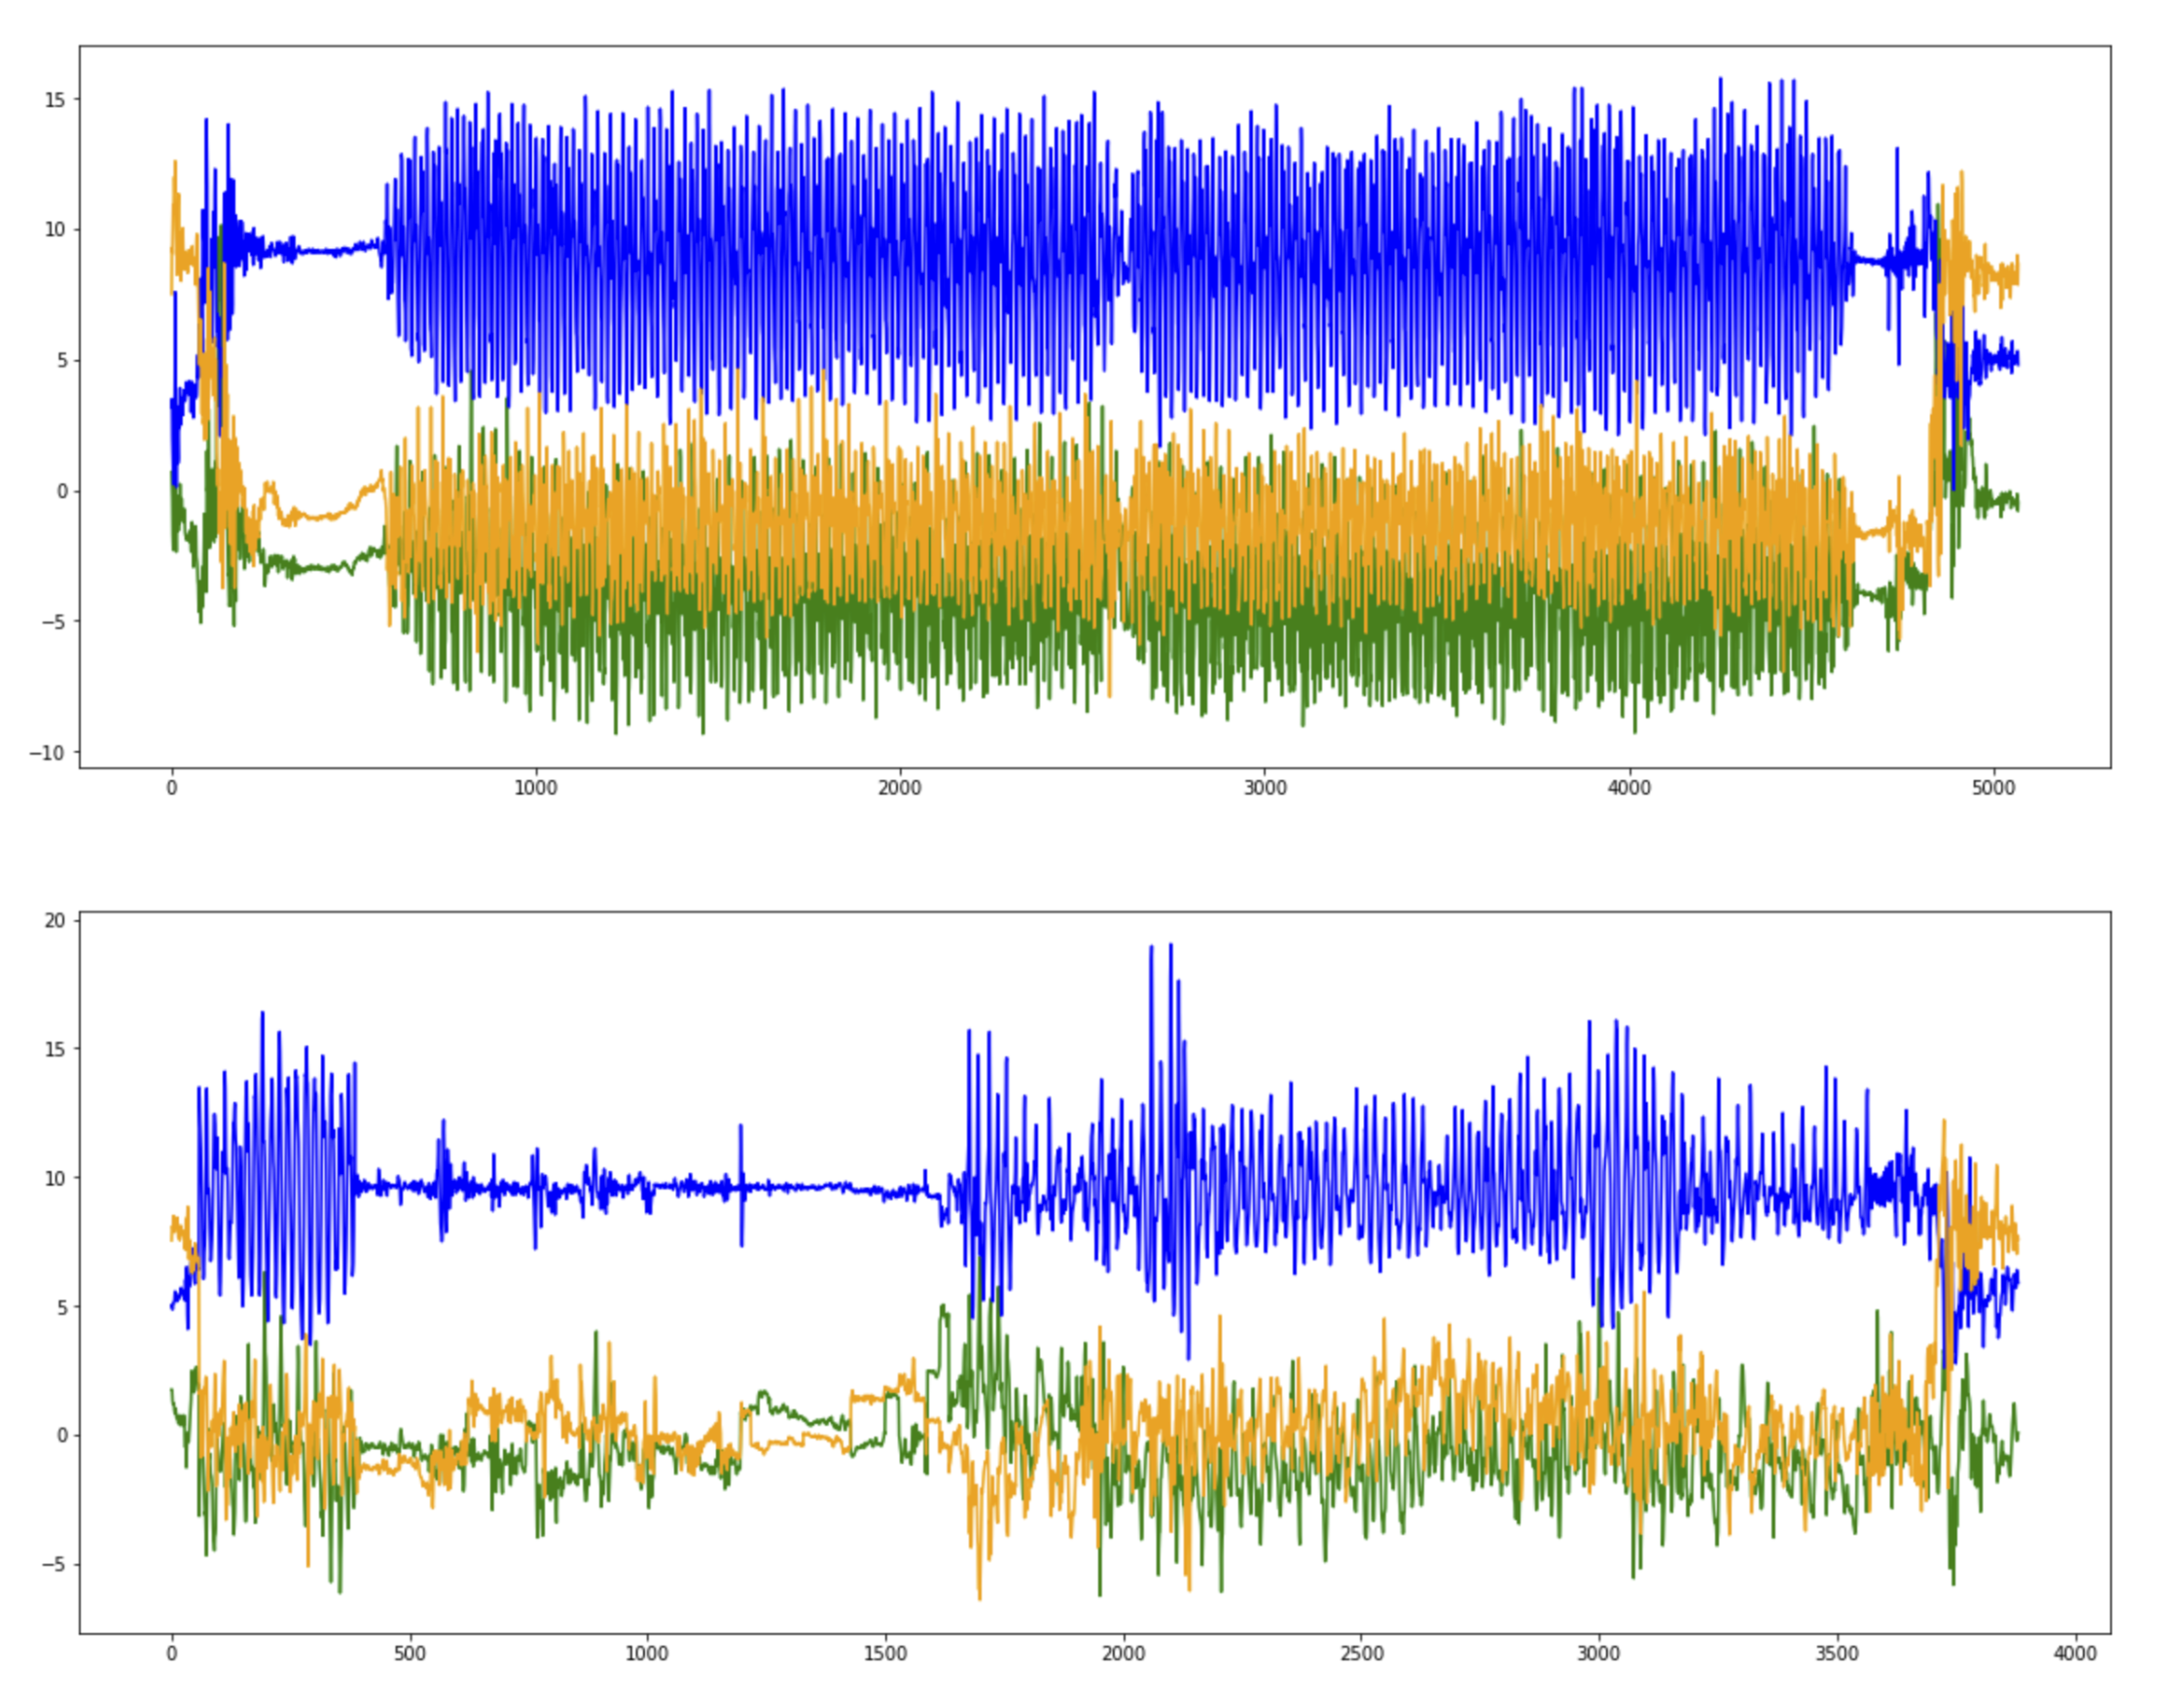










**2. Device Orientation matters** 

Device orientation adds a rotational offset to the acceleration observations, and this needs to be removed to have all observations available in a canonical reference frame, say, with y-axis aligned with gravity direction.

Another observation is that some participants adjusted the device midway. For example: participant 13 readjusted the device:

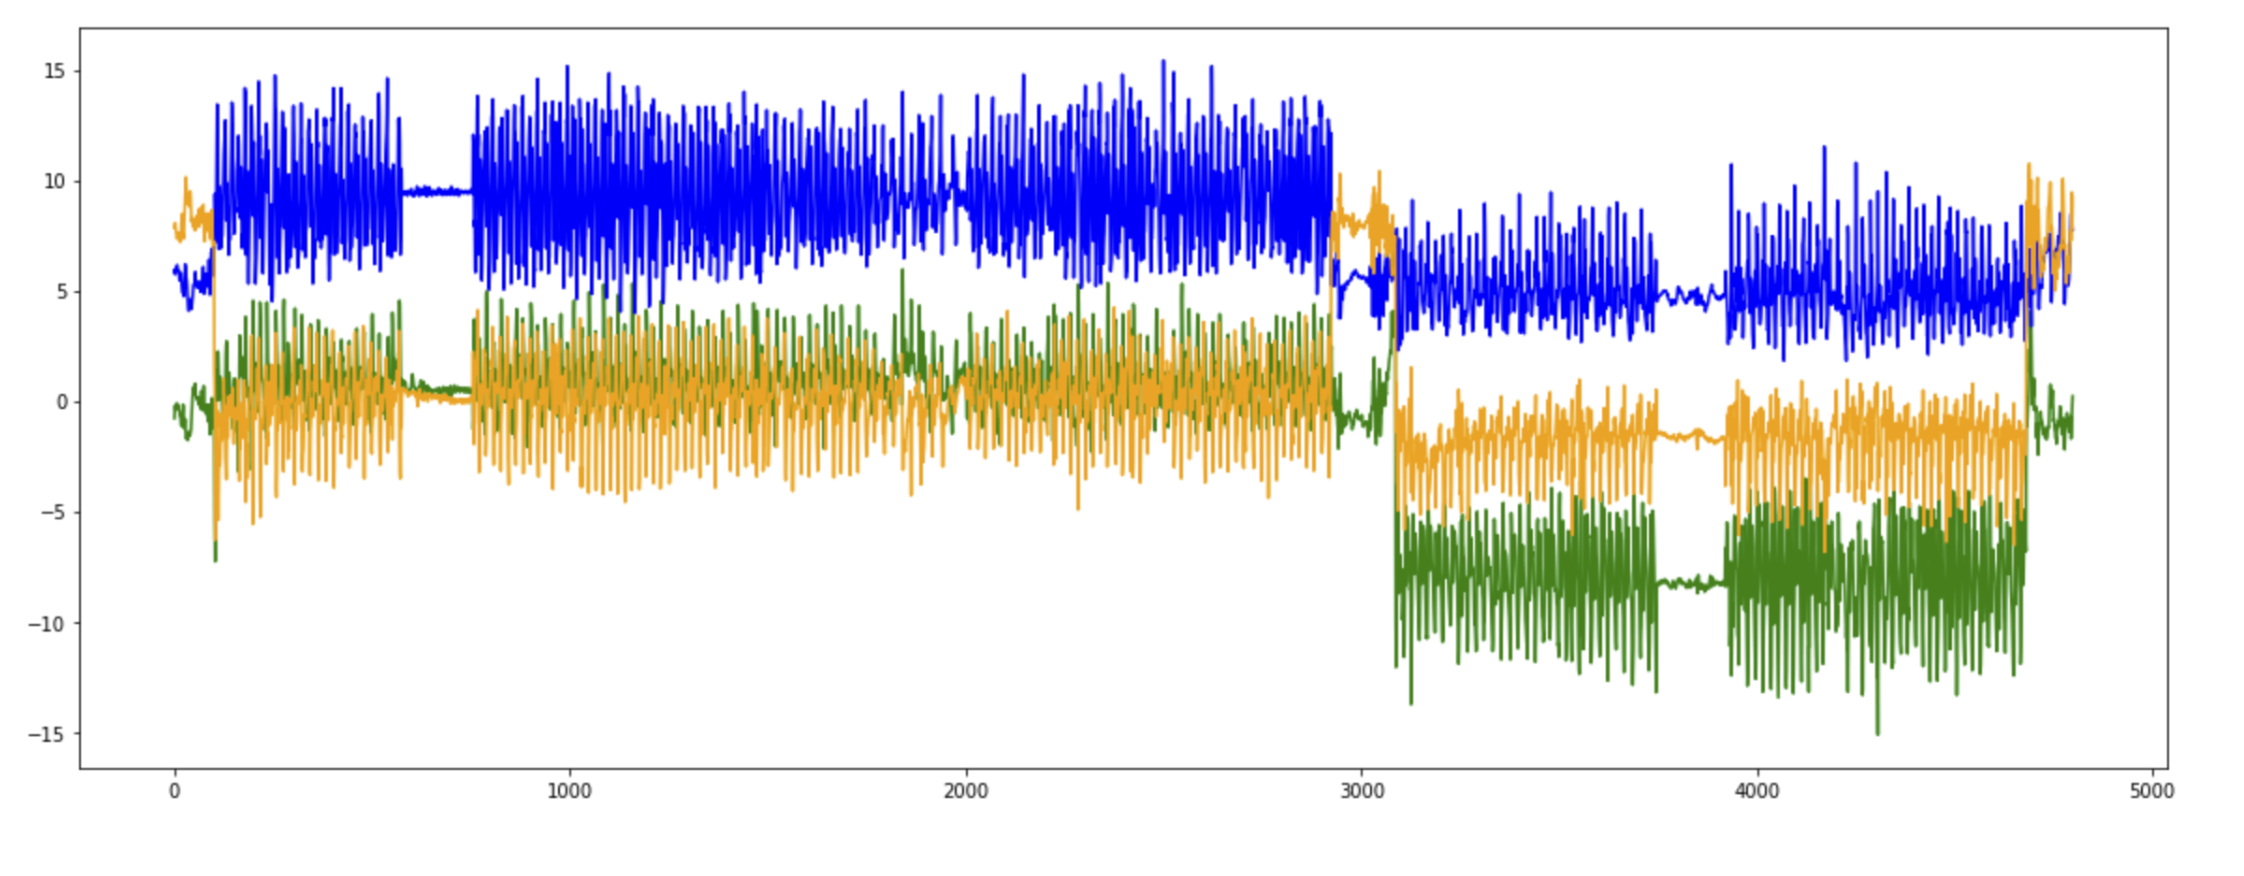



**3. Participants are Walking Different Distances**

Some paarticipant are walking longer than the others. Although the dataset and the orignal paper mentions that the data was captured for at least 15 mins at 52Hz, the number of samples for most users are way below 46800 (=52x15x60) samples. 

**Methodology**

**Clean up**

We used 2s window with no overlap to analyze the data because it contains about 100 observations which we could use to determine if it indeed corespond to walking activity. The criteria we used was the standard deviation of the observations should be more than 10% of the gravity to be represent walking activity. After labeling all windows in the entire sequence, we selected the longest segment to represent users' walking activity. This way we implicitly avoided the another source of error in the signal during start and the end. 

**Features** 

Mean
Standard Deviation
Minimum Value
Maximum value
Auto correlation mean
Auto correlation standard deviation
Auto covariance mean
Auto covariance standard deviation
Skewness
Kurtosis value
Deviation from mean


Most of the above mentioned features were included these variables the original paper takes them into account as well. 


**Longest Active Segment**

In [ ]:
def locate_longest_active_sequence(df):
    longest_seq = []
    active_seq = []
    for i in range(0, df.shape[0], 50):
        x = is_active(df, i, i+100)
        if not x and len(longest_seq) < len(active_seq):
            longest_seq = active_seq
            active_seq = []
        elif x:
            active_seq.append(i)
        else:
            active_seq =[]
    return longest_seq[0], longest_seq[-1]
 

**Feature Extraction**

In [421]:
def extract_feature_from(raw_data, start, end):
    acf = stattools.acf(raw_data[start:end])
    acv = stattools.acovf(raw_data[start:end])
    sqd_error = (raw_data[start:end] - raw_data[start:end].mean()) ** 2
    return [
        raw_data[start:end].mean(),
        raw_data[start:end].std(),
        raw_data[start:end].min(),
        raw_data[start:end].max(),
        acf.mean(), # mean auto correlation
        acf.std(), # standard deviation auto correlation
        acv.mean(), # mean auto covariance
        acv.std(), # standard deviation auto covariance
        skew(raw_data[start:end]),
        kurtosis(raw_data[start:end]),
        math.sqrt(sqd_error.mean())]
    

**Average acceleration**

In [422]:
# 1
def average_acceleration(df, start, end):
    ax_mean = df['x'][start:end].mean()
    # assuming the device is verticle and aligned with the y asix of the phone
    ay_mean_wo_gravity =  df['y'][start:end].mean() - 9.81
    az_mean = df['z'][start:end].mean()
    return np.linalg.norm([ax_mean, ay_mean, az_mean])

**Average time between observations for a user**

In [ ]:
# 2
def average_gap_btw_samples(df, start, end):
    del_t = df['timestamp'][start:end] - df['timestamp'][start:end].shift(-1)
    return del_t.mean()

**Use the query language of your choice to create the feature engineered
dataset you described above**


In [ ]:
# feature 3
pre_processed_data = []
figure, axes = plt.subplots(nrows=23, ncols=1, figsize=(20, 200))
for user_id in range(1, 23):
#     print("user {}".format(user_id))
    csv_filename = "{}.csv".format(user_id)
    full_csv_filepath = os.path.join("/Users/manjulamishra/Downloads/User Identification From Walking Activity/", csv_filename)
    data = prepare_data_for_each_user(full_csv_filepath)
    pre_processed_data = pre_processed_data + data
    axes[user_id].plot(df['x'], color = 'g');
    axes[user_id].plot(df['y'], color = 'b');
    axes[user_id].plot(df['z'], color = 'orange');


## Conclusion

Looking at this data, we realized that 

**Pros and Cons of Our Approach:**

**Pros:**

High accuracy 

Successful segmentation of active windows


**Cons**

Didn't remove some of the classes with outliers

Couldn't take the orientation facts into consideration

More features generation

**Next Steps**

Would use High filter

Take care of class imbalance 

resampling to match it with health data

More data

deep leaning


**References:**

https://archive.ics.uci.edu/ml/datasets/User+Identification+From+Walking+Activity

https://www.scitepress.org/Papers/2011/33299/33299.pdf

http://www.csis.pace.edu/~ctappert/papers/proceedings/2016BTAS/Papers/AnEmpericalEvaluationOfActivities.pdf

https://github.com/theumairahmed/User-Identification-and-Classification-From-Walking-Activity/blob/master/Report_UmairAhmed.pdf

https://blog.contus.com/how-to-measure-acceleration-in-smartphones-using-accelerometer/

https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/

https://github.com/greek-geek/Human-Activity-Recognition/blob/master/Final_code.ipynb

https://machinelearningmastery.com/one-class-classification-algorithms/

https://dev.to/stevenbruno/an-introduction-to-one-class-classification-2m5c

In [1]:
# importing all the important imports 
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import skew, kurtosis
from statsmodels.tsa import stattools
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
def compute_position(df, start, end):
    ax = df['x'][start:end] 
    ay = df['y'][start:end] - 9.81
    az = df['z'][start:end]
    del_t = df['timestamp'] - df['timestamp'].shift(-1)
    del_t_sq = del_t*del_t
    displacement_x = 0.5*ax*del_t_sq
    displacement_y = 0.5*ay*del_t_sq
    displacement_z = 0.5*az*del_t_sq
    return [displacement_x.sum(), displacement_y.sum(), displacement_z.sum()]


def compute_abs_position(df):
    x_dis = df['displacement_x']
    y_dis = df['displacement_y']
    z_dis = df['displacement_z']
    df['position_x'] = pd.Series([0]).append(x_dis, ignore_index=True).cumsum()
    df['position_y'] = pd.Series([0]).append(y_dis, ignore_index=True).cumsum()
    df['position_z'] = pd.Series([0]).append(z_dis, ignore_index=True).cumsum()
    return df

def compute_magnitude(df):
    x2 = df['x_std'] * df['x_std']
    y2 = df['y_std'] * df['y_std']
    z2 = df['z_std'] * df['z_std']
    m2 = x2 + y2 + z2
    df['magnitude'] = m2.apply(lambda x: math.sqrt(x))
    return df

def read_into_df_for_each_user(data_filename):
    df = pd.read_csv(data_filename, header=None)
    df = df.rename(columns={0:'timestamp', 1:'x', 2:'y', 3:'z' })
    df = standarize_acceleration(df)
    df = compute_magnitude(df)
    
    return df

def is_active(df, start, end):
    window = df['magnitude'][start:end]
    window_std = window.std()
    g = 9.81
    return window_std > 0.1*g
  
def extract_feature_from(raw_data, start, end):
    acf = stattools.acf(raw_data[start:end])
    acv = stattools.acovf(raw_data[start:end])
    sqd_error = (raw_data[start:end] - raw_data[start:end].mean()) ** 2
    return [
        raw_data[start:end].mean(),
        raw_data[start:end].std(),
        raw_data[start:end].min(),
        raw_data[start:end].max(),
        acf.mean(), # mean auto correlation
        acf.std(), # standard deviation auto correlation
        acv.mean(), # mean auto covariance
        acv.std(), # standard deviation auto covariance
        skew(raw_data[start:end]),
        kurtosis(raw_data[start:end]),
        math.sqrt(sqd_error.mean())
    ]
    
def locate_longest_active_sequence(df):
    longest_seq = []
    active_seq = []
    for i in range(0, df.shape[0], 50):
        x = is_active(df, i, i+100)
        if not x and len(longest_seq) < len(active_seq):
            longest_seq = active_seq
            active_seq = []
        elif x:
            active_seq.append(i)
        else:
            active_seq =[]
    return longest_seq[0], longest_seq[-1]

def standarize_acceleration(df):
    df['x_std'] = df['x'] - df['x'].mean()
    df['y_std'] = df['y'] - df['x'].mean()
    df['z_std'] = df['z'] - df['x'].mean()
    return df
 
# feature 1
def average_gap_btw_samples(df, start, end):
    del_t = df['timestamp'][start:end] - df['timestamp'][start:end].shift(-1)
    return del_t.mean()

# feature 2
def average_acceleration(df, start, end):
    ax_mean = df['x'][start:end].mean()
    # assuming the device is verticle and aligned with the y asix of the phone
    ay_mean_wo_gravity =  df['y'][start:end].mean() - 9.81
    az_mean = df['z'][start:end].mean()
    return np.linalg.norm([ax_mean, ay_mean, az_mean])
    
    
def split_and_extract_features_from(df, label):
    start_loc, end_loc = locate_longest_active_sequence(df)
#     print(start_loc, end_loc)
    labeled_data = []
    for i in range(start_loc, end_loc, 50):
        feature_mag = extract_feature_from(df['magnitude'], i, i+100)
        feature_x = extract_feature_from(df['x_std'], i, i+100)
        feature_y = extract_feature_from(df['y_std'], i, i+100)
        feature_z = extract_feature_from(df['z_std'], i, i+100)
        feature = feature_mag + feature_x + feature_y + feature_z
        feature.append(label)
        labeled_data.append(feature)
            
    print(len(labeled_data), len(labeled_data[0]))
    return labeled_data

def find_inactive_windows(df, ax):
    for i in range(0, df.shape[0], 100):
        if is_inactive(df, i, i+100):
            ax.axvline(x=i, color='r')
            ax.axvline(x=i+99, color='r')
            
def prepare_data_for_each_user(csv_filename):
    df = read_into_df_for_each_user(csv_filename)
    data = split_and_extract_features_from(df, user_id)
    return data, df

user 1
80 45
user 2
34 45
user 3
12 45
user 4
58 45
user 5
15 45
user 6
96 45
user 7
66 45
user 8
35 45
user 9
53 45
user 10
59 45
user 11
98 45
user 12
44 45
user 13
72 45
user 14
47 45
user 15
69 45
user 16
23 45
user 17
73 45
user 18
113 45
user 19
12 45
user 20
334 45
user 21
17 45
user 22
79 45


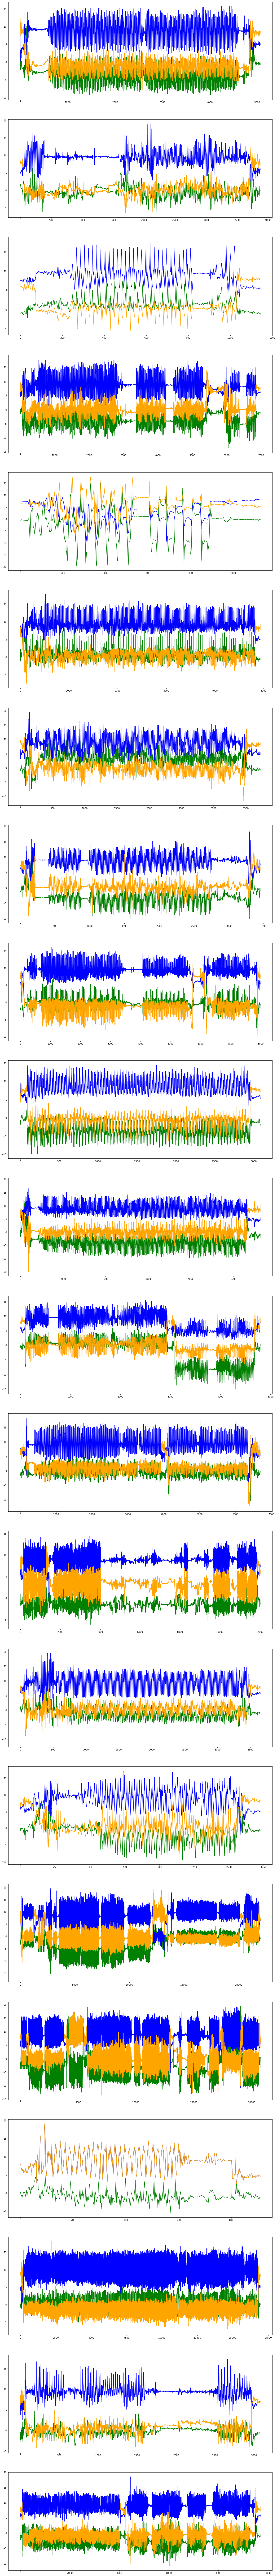

In [24]:
# feature 3
pre_processed_data = []
figure, axes = plt.subplots(nrows=22, ncols=1, figsize=(20, 200))
for user_id in range(1, 23):
    print("user {}".format(user_id))
    csv_filename = "{}.csv".format(user_id)
    full_csv_filepath = os.path.join("/Users/manjulamishra/Downloads/User Identification From Walking Activity/", csv_filename)
    data,df = prepare_data_for_each_user(full_csv_filepath)
    pre_processed_data = pre_processed_data + data
    i = user_id-1
    axes[i].plot(df['x'], color = 'g');
    axes[i].plot(df['y'], color = 'b');
    axes[i].plot(df['z'], color = 'orange');



In [15]:
data = pd.DataFrame(pre_processed_data)

In [16]:
data.shape

(1489, 45)

[Results For  Baseline Classifier ] Mean:  0.08732541266098312  Std Dev:  0.016836248815801133
[Results For  Random Forest Classifier ] Mean:  0.8515372755305641  Std Dev:  0.10014780897156217
[Results For  KNN ] Mean:  0.8992336296027572  Std Dev:  0.07320424451296936
[Results For  Decision Tree ] Mean:  0.7622301832033375  Std Dev:  0.07466188133134617
[Results For  Linear SVM ] Mean:  0.9207282786141846  Std Dev:  0.06305891371188412
[Results For  RBF SVM ] Mean:  0.2357337202974787  Std Dev:  0.009345764313163146


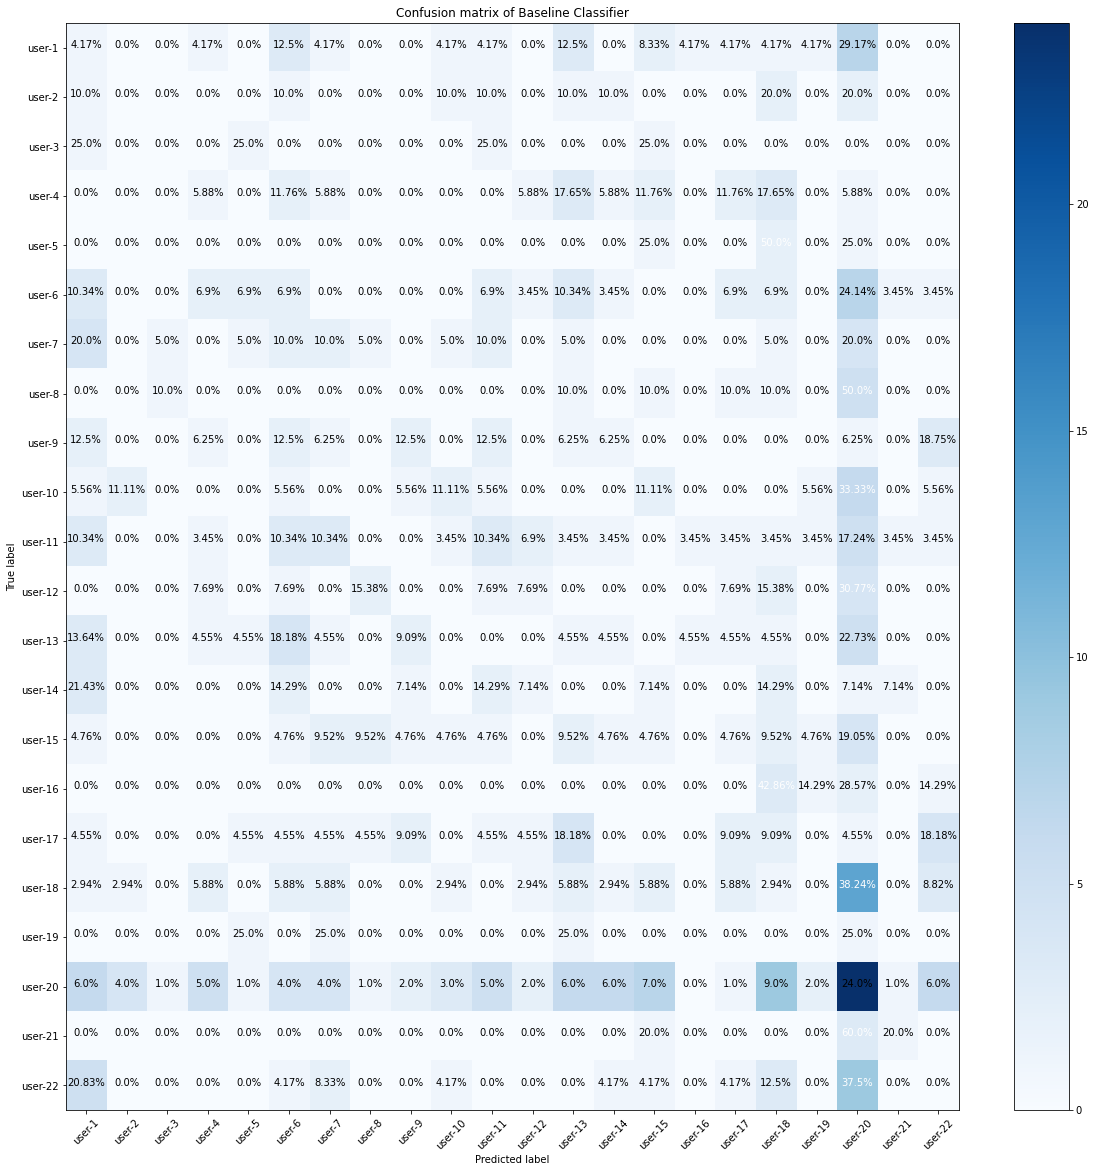

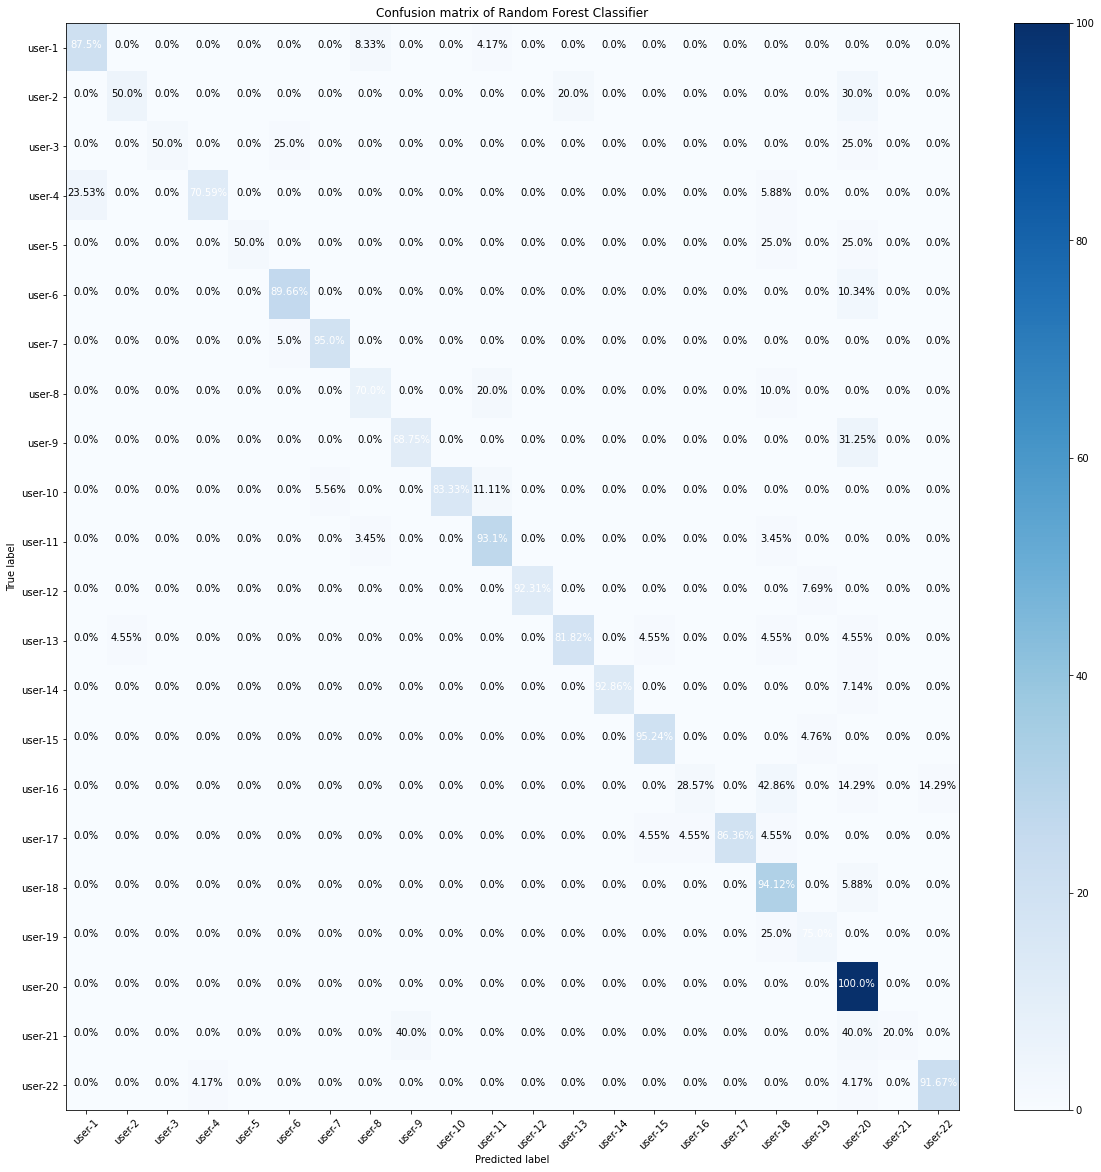

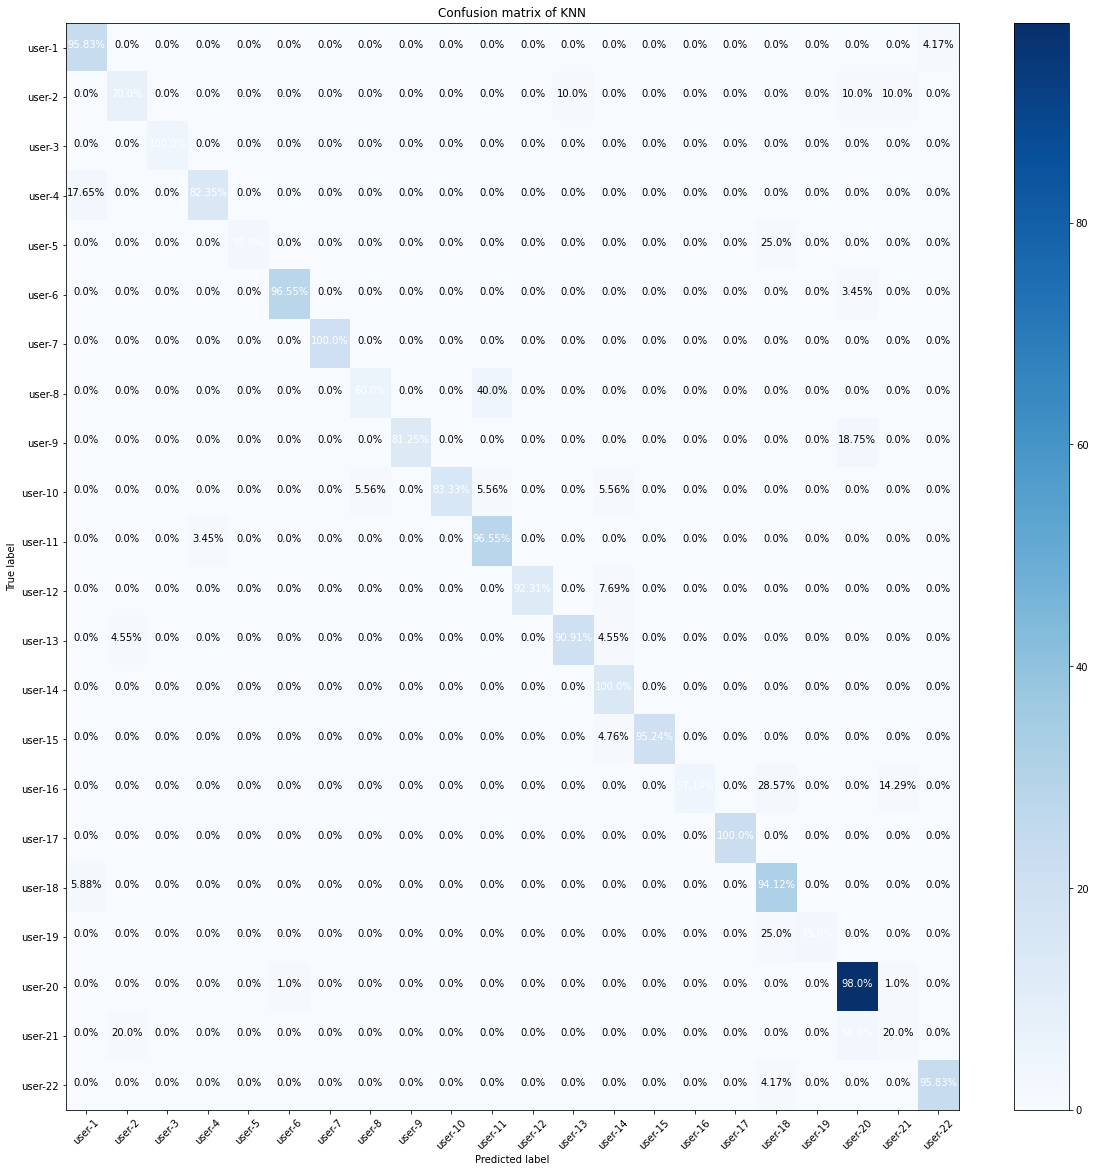

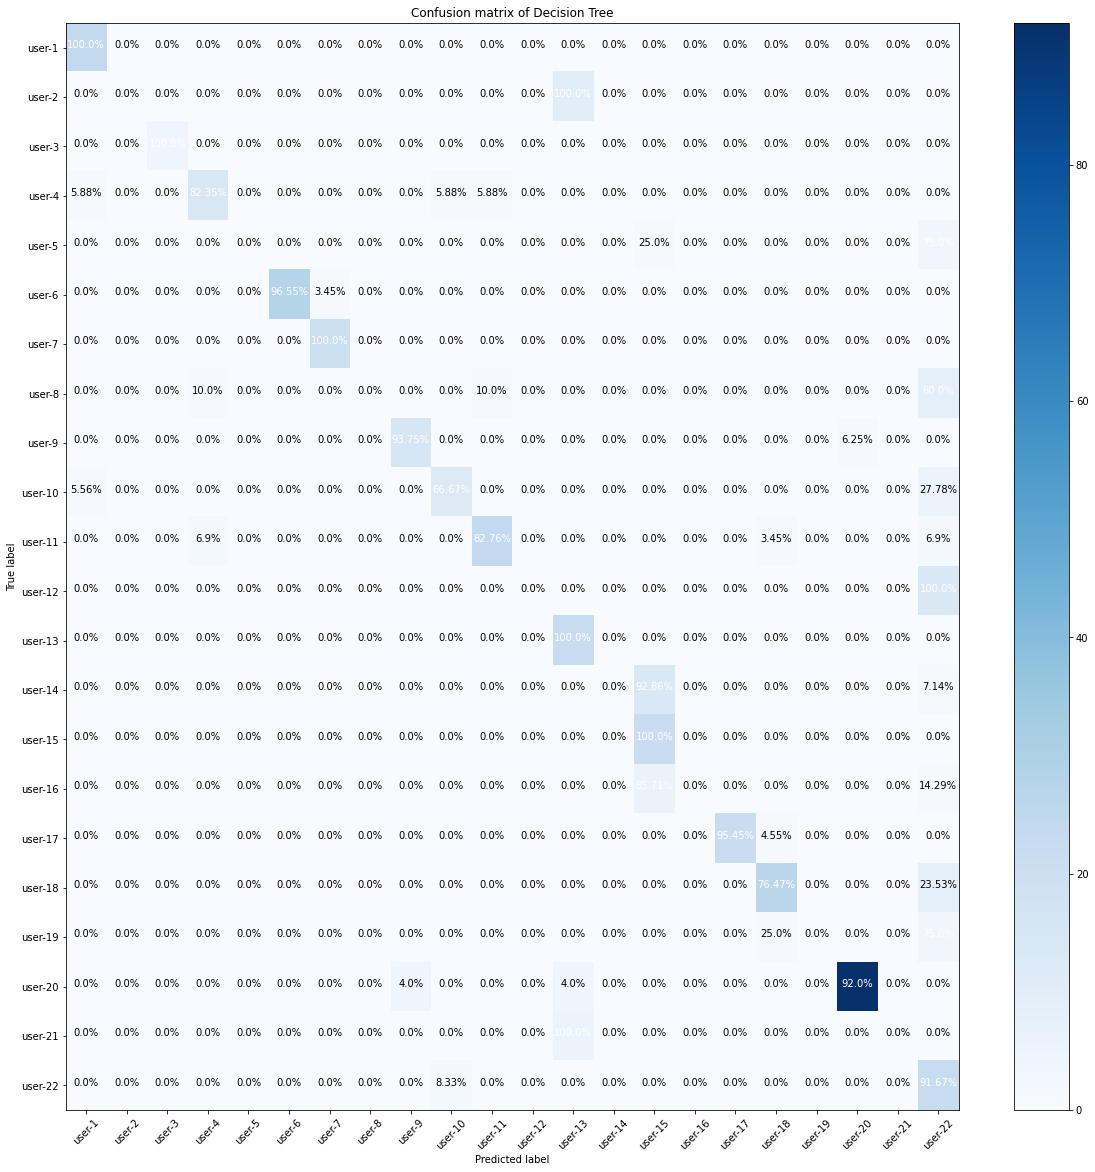

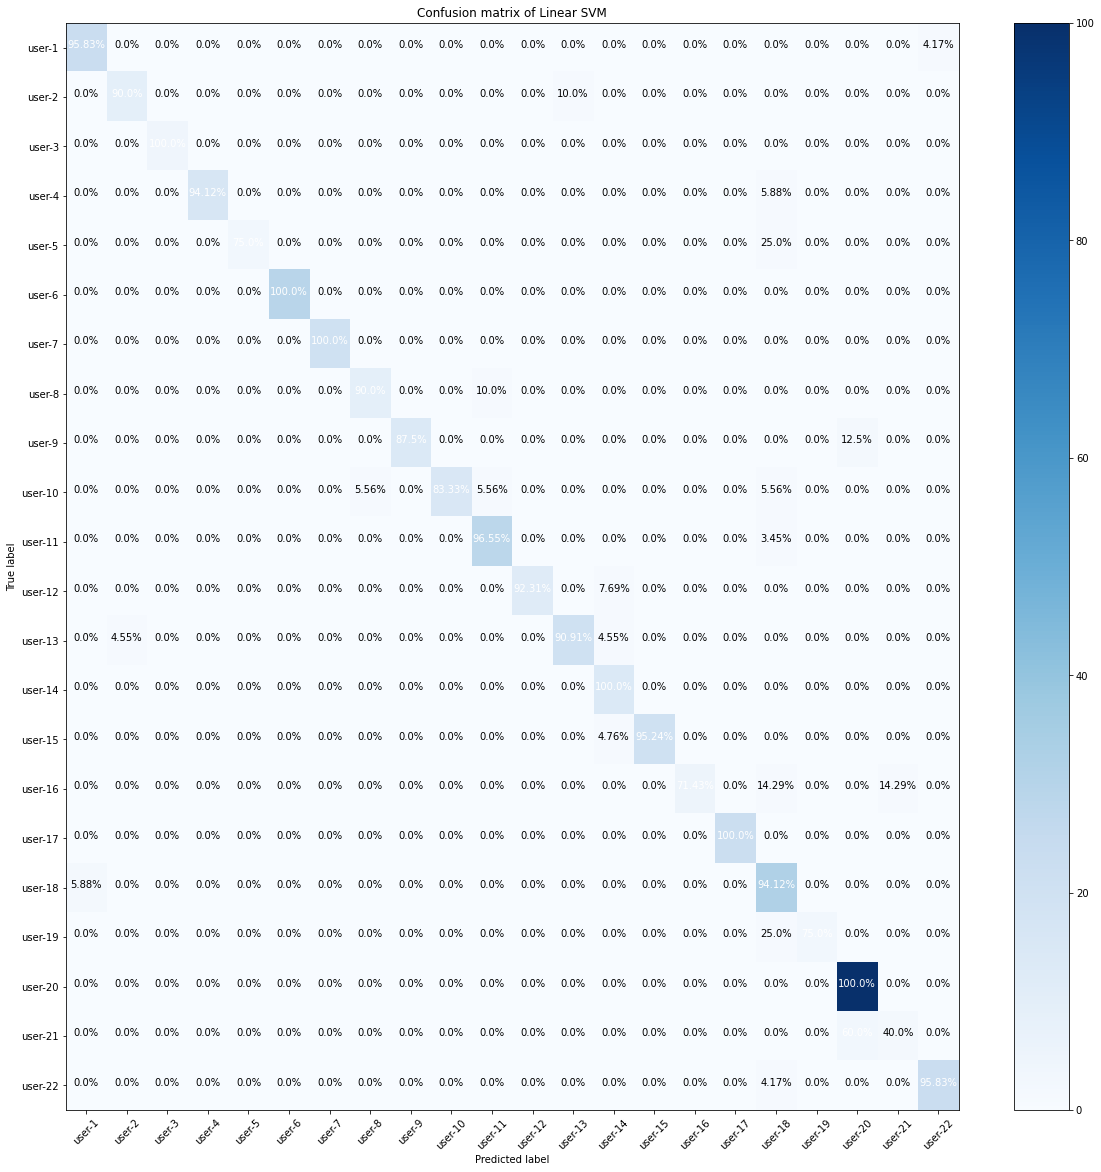

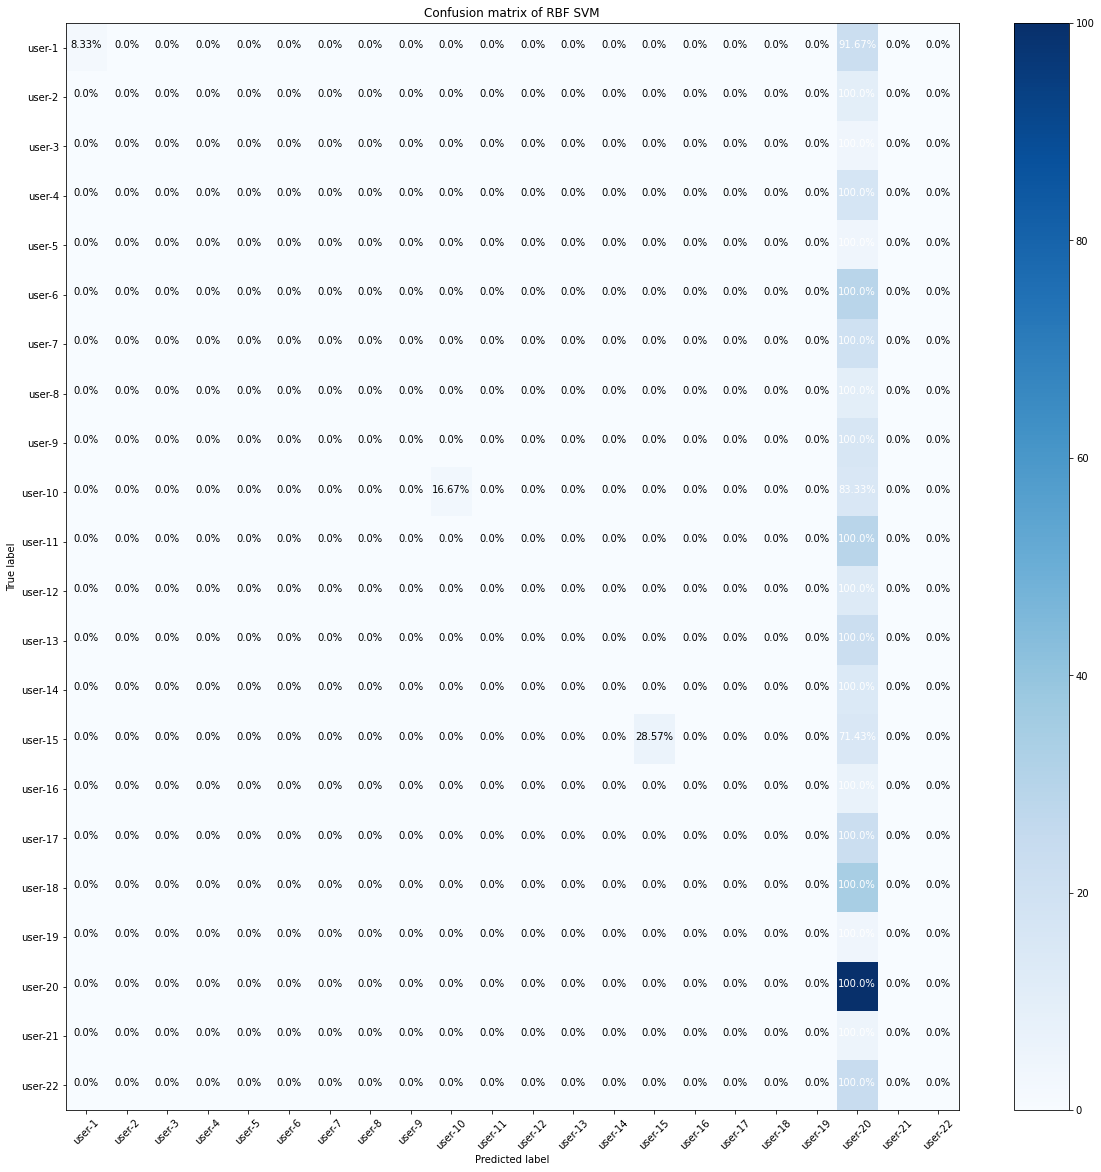

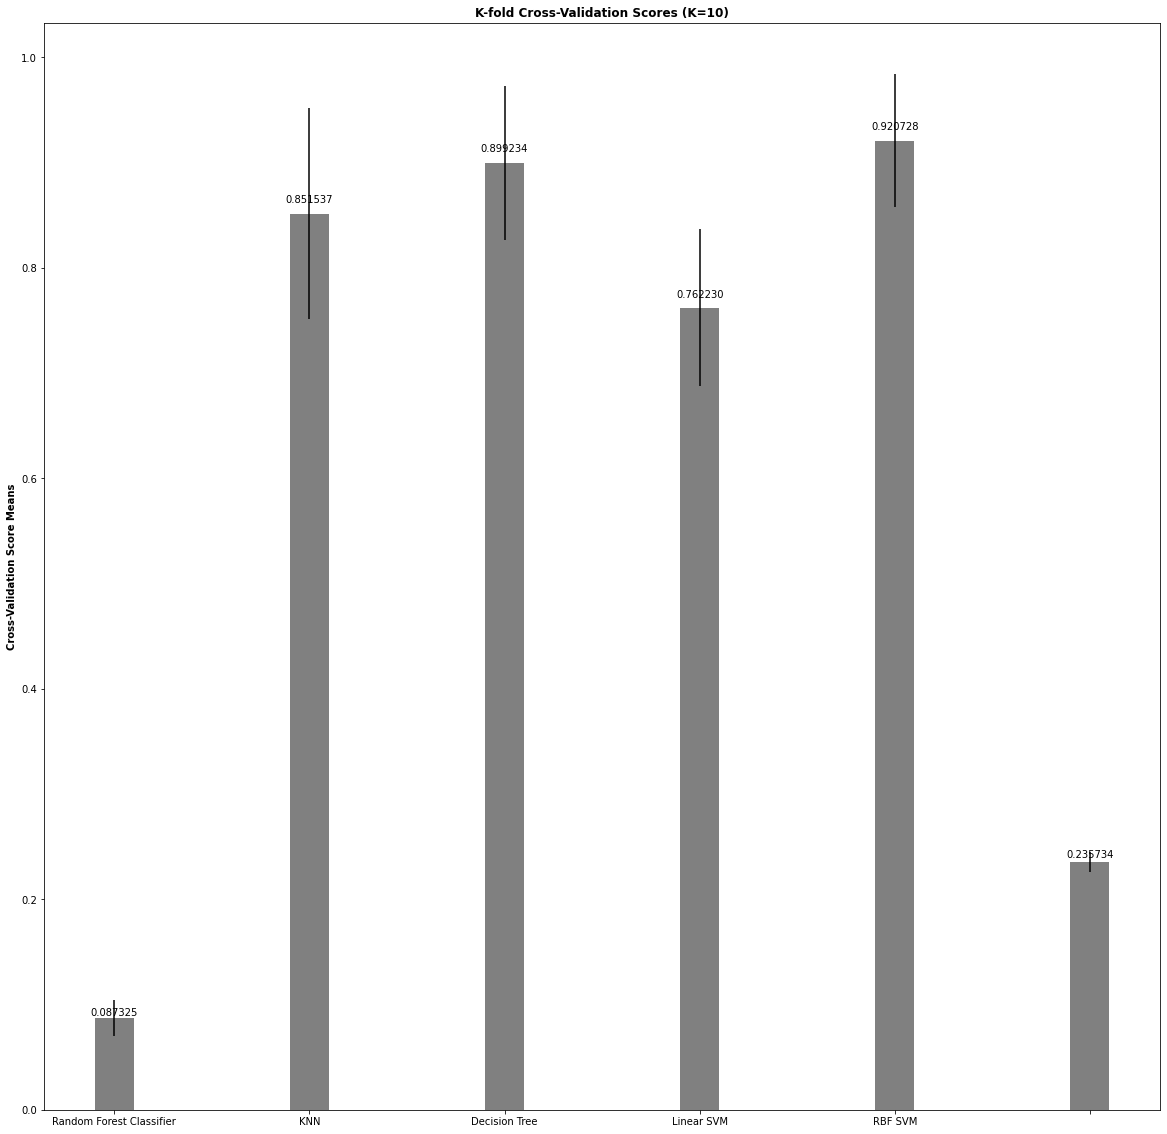

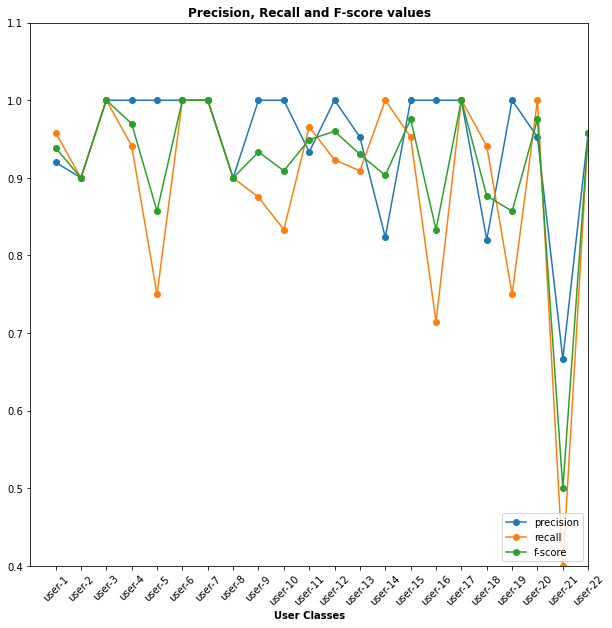

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.svm import SVC



#Method for computing and plotting the confusion matrix, taken and modified from sklearn's official documentation website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(round(cm[i, j],2))+'%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Method for labelling the bar chart bars, taken from Matplotlib documentation
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%f' % float(height),
                ha='center', va='bottom')
    
        
        
    
'''
 Main code begins from here
'''
#Note on Numpy array splicing
 
dataset = np.array(pre_processed_data)
X = dataset[:, 0:-1]
y = dataset[:, -1]      
class_names = ['user-1','user-2','user-3','user-4','user-5','user-6','user-7','user-8','user-9','user-10','user-11','user-12','user-13','user-14','user-15','user-16','user-17','user-18','user-19','user-20','user-21','user-22']



classifiers = {'Baseline Classifier':DummyClassifier(),'Random Forest Classifier':RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1), 'KNN':KNeighborsClassifier(10),'Decision Tree':DecisionTreeClassifier(max_depth=6),'Linear SVM':SVC(kernel="linear", C=0.025),'RBF SVM':SVC(gamma=2, C=1)}
classifiers_title = list(classifiers.keys())               
scores=np.empty(10)
means_scores=[]
stddev_scores=[]

#dividing the dataset into training and testing (training 70% and test=30%)
X_train,X_test,y_train,y_test = train_test_split (X,y, stratify = y, test_size=0.3)


#Performing classification using each classifier and computing the 10-Fold cross-validation on results
for i in range(classifiers.__len__()):
    classifiers[classifiers_title[i]].fit (X_train,y_train)
    y_pred = classifiers[classifiers_title[i]].predict(X_test)
    scores = cross_val_score(classifiers[classifiers_title[i]],X,y,cv=10)
    # Plot normalized confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title=('Confusion matrix of ' + classifiers_title[i]))
    mean = scores.mean()
    stdev = scores.std()
    means_scores.append(mean)
    stddev_scores.append(stdev)
    print("[Results For ",classifiers_title[i], "] Mean: ",mean," Std Dev: ",stdev)
   

 #plotting the bar chart showing each classifier's mean and std deviation of cross-validation score
fig,ax= plt.subplots(figsize=(20,20))
rect1 = ax.bar(np.arange(6),means_scores,0.2,color='gray',yerr=stddev_scores)
ax.set_title('K-fold Cross-Validation Scores (K=10)',weight='bold')
ax.set_xticklabels(classifiers_title)
ax.set_ylabel('Cross-Validation Score Means',weight='bold')
autolabel(rect1)


#calculating the precision, recall, fscore and support for the best classifier i.e. Linear SVM
y_pred = classifiers['Linear SVM'].predict(X_test)
prec_rec_fscore_supt = precision_recall_fscore_support(y_test,y_pred)

# #plotting precision,recall and fscore values for each class of users
fig,ax = plt.subplots(figsize=(10,10))
x= np.arange(1,23)
ax.plot(x,prec_rec_fscore_supt[0],'o-');
ax.plot(x,prec_rec_fscore_supt[1],'o-');
ax.plot(x,prec_rec_fscore_supt[2],'o-');

ax.set_ylim(0.4,1.1)
ax.set_xlim(0,22)
ax.legend(['precision','recall','f-score'],loc='lower right')
ax.set_xlabel ('User Classes',weight='bold')
ax.set_title ('Precision, Recall and F-score values',weight='bold')

plt.xticks(x, class_names, rotation=45);

